In [54]:
from src.models.decisiontrees.xgboost import XGB1
from src.models.decisiontrees.catboost import CatBoost1
from src.models.decisiontrees.lightgbm import LGBM1
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [79]:
historical_metering = pd.read_csv("data/datasets2025/historical_metering_data_ES.csv")
rollout = pd.read_csv("data/datasets2025/rollout_data_ES.csv")

historical_copy = historical_metering.copy()
historical_copy['DATETIME'] = pd.to_datetime(historical_copy['DATETIME'])
historical_copy.set_index('DATETIME', inplace=True)
rollout_copy = rollout.copy()

In [4]:
historical_datetimes = historical_metering["DATETIME"]
rollout_datetimes = rollout["DATETIME"]
common_dates = set(historical_datetimes).intersection(rollout_datetimes)


In [21]:
historical_data = historical_metering[historical_metering["DATETIME"].isin(common_dates)].to_numpy()
rollout_data = rollout[rollout["DATETIME"].isin(common_dates)].to_numpy()
common_dates = list(common_dates)

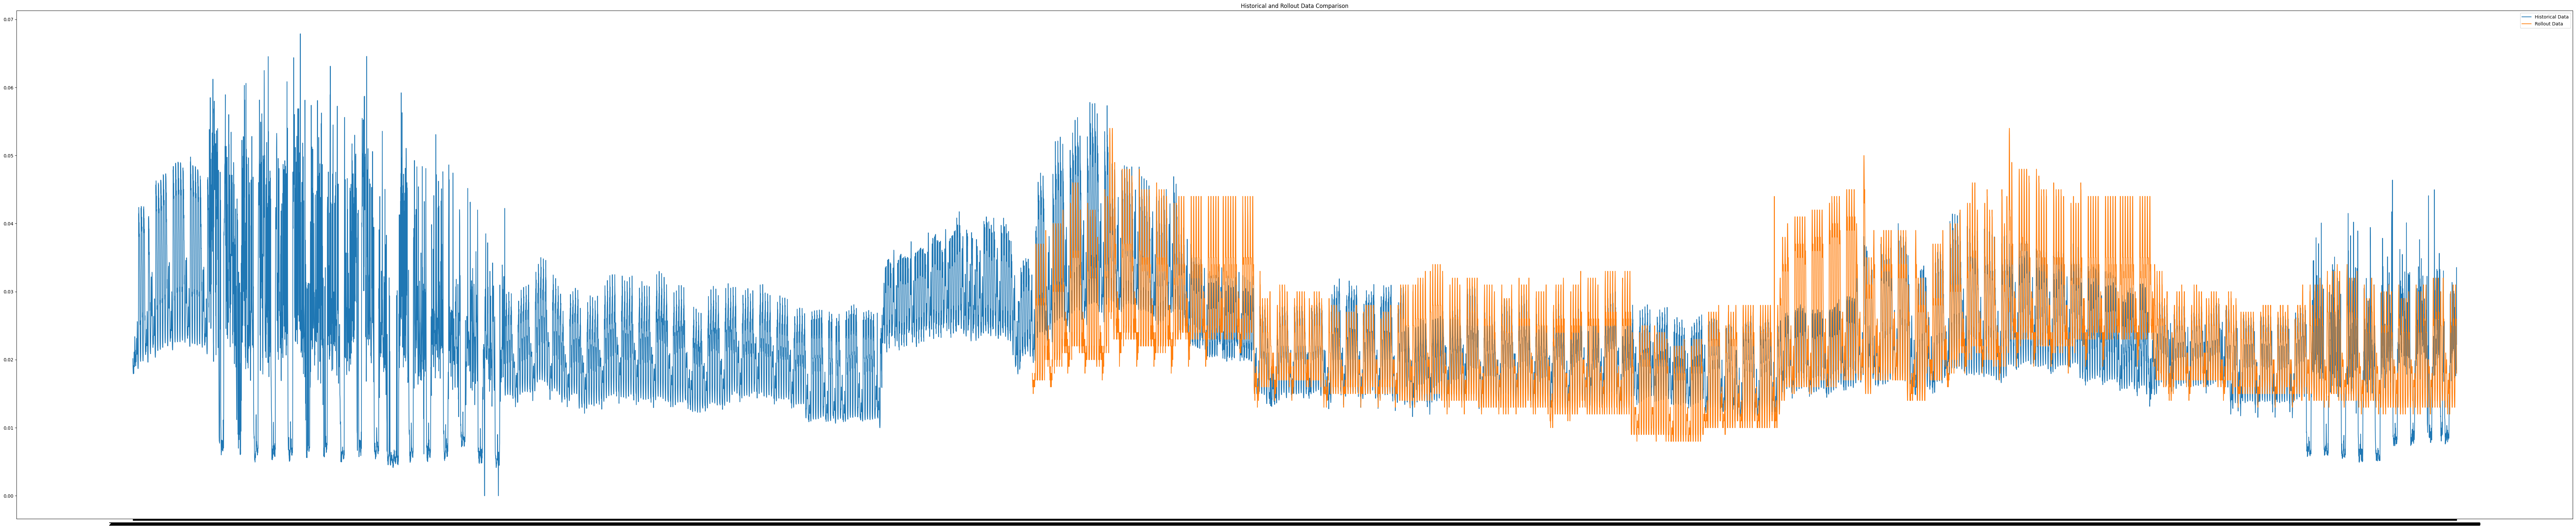

In [22]:
fig = plt.figure(figsize=(100, 20))
plt.plot(common_dates, historical_data[:, 3], label="Historical Data")
plt.plot(common_dates, rollout_data[:, 3], label="Rollout Data")
plt.title("Historical and Rollout Data Comparison")
plt.legend()
plt.show()

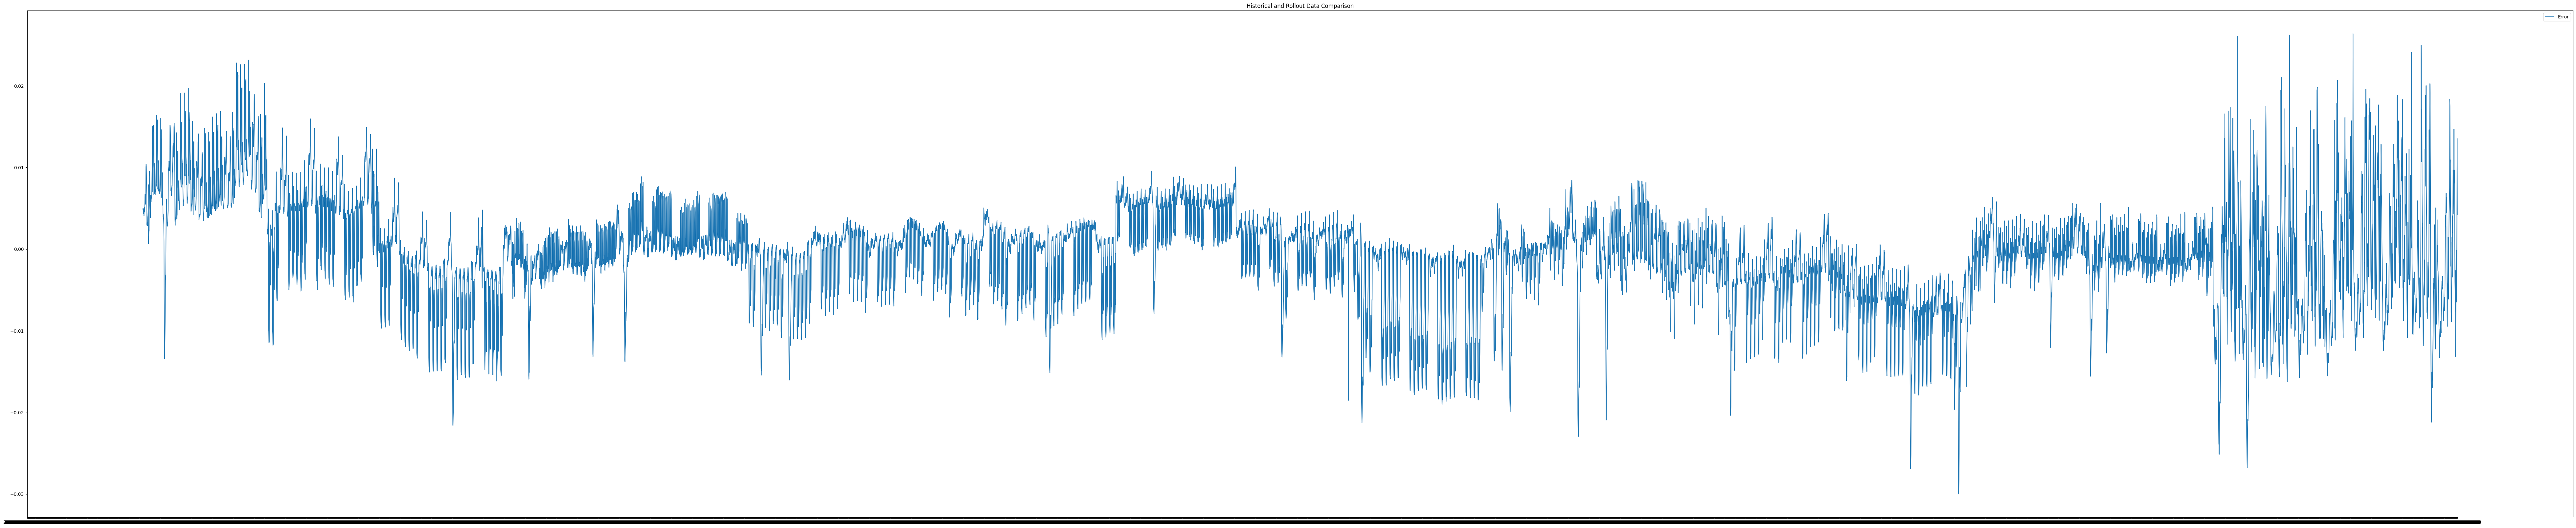

In [23]:
fig = plt.figure(figsize=(100, 20))
plt.plot(common_dates, historical_data[:, 3]-rollout_data[:, 3], label="Error")
plt.title("Historical and Rollout Data Comparison")
plt.legend()
plt.show()

In [44]:

max_lag = len(historical_copy)
lags = range(1,max_lag + 1)
autocorrelations = [historical_copy['VALUEMWHMETERINGDATA_customerES_5'].autocorr(lag=lag) for lag in lags]
top_10_lags = sorted(range(len(autocorrelations)), key=lambda i: abs(autocorrelations[i]), reverse=True)[:10]
print("Top 10 Lags:", top_10_lags)

Top 10 Lags: [22626, 0, 1, 167, 2, 166, 335, 168, 334, 336]


In [106]:
cutoff = pd.to_datetime('2024-07-01 00:00:00')

n_customer = 5
customer_data = historical_copy[f'VALUEMWHMETERINGDATA_customerES_{n_customer}']
customer_data = customer_data.to_frame()
customer_data['week_ahead'] = customer_data.shift(-24*7)
training_data = customer_data[customer_data.index < cutoff]
test_data = customer_data[customer_data.index >= cutoff]

In [109]:
td_1 = training_data[f'VALUEMWHMETERINGDATA_customerES_{n_customer}'].to_numpy()
tt_1 = training_data['week_ahead'].to_numpy()

ted_1 = test_data[f'VALUEMWHMETERINGDATA_customerES_{n_customer}'].to_numpy()
tet_1 = test_data['week_ahead'].to_numpy()

In [ ]:
len_week = 7 * 24
n_weeks = len(training_data) // (7 * 24)
X_train = np.empty((n_weeks, len_week))
y_train = np.empty((n_weeks,))
X_test = np.empty((n_weeks, len_week))
y_test = np.empty((n_weeks,))

for i in range(n_weeks):
    X_train[i] = td_1[i * len_week:(i + 1) * len_week]
    y_train[i] = tt_1[i * len_week + len_week - 1]



In [57]:
model  = XGB1()

In [111]:
model.fit(X_train, y_train)